In [169]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pulp
import warnings
warnings.simplefilter("ignore")

import spaghetti


from map_plotter import plot_results_on_map


%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 12
sns.set_style('darkgrid')

# Facility Location Problem Benchmarking

Сделано на основе работы Germano Barcelos, James Gaboardi, Levi J. Wolf, Qunshan Zhao.


In [170]:
from pulp import PULP_CBC_CMD, SCIP_PY, GLPK_CMD, HiGHS

def benchmarking_results(model, value_name, mclp_model = False):
    solvers = ["PULP_CBC_CMD", "SCIP_PY", 'GLPK_CMD', 'HiGHS'] # List of solvers
    results = pd.DataFrame(columns=[value_name, "Time (in sec.)"], index=solvers)

    for solver in solvers:
        if solver == "PULP_CBC_CMD":
            _model = model.solve(PULP_CBC_CMD(msg=False))
        elif solver == "GLPK_CMD":
            _model = model.solve(GLPK_CMD(msg=False))
        elif solver == 'SCIP_PY':
            _model = model.solve(SCIP_PY(msg=False))
        elif solver == 'HiGHS':
            _model = model.solve(HiGHS(msg=False))
        if mclp_model:
            results.loc[solver] = [_model.perc_cov, _model.problem.solutionTime]
        else:
            results.loc[solver] = [_model.problem.objective.value(), _model.problem.solutionTime]
    return results

# Synthetic Data Benchmarking

## LSCP

In [171]:
CLIENT_COUNT = 100
FACILITY_COUNT = 10

SERVICE_RADIUS = 8
CLIENT_SEED = 42
FACILITY_SEED = 42
np.random.seed(42)

In [172]:
from spopt.locate import simulated_geo_points

lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)
streets = spaghetti.element_as_gdf(ntw, arcs=True)
streets_buffered = gpd.GeoDataFrame(
    gpd.GeoSeries(streets["geometry"].buffer(0.5).unary_union),
    crs=streets.crs,
    columns=["geometry"],
)

client_points = simulated_geo_points(
    streets_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED
)
facility_points = simulated_geo_points(
    streets_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

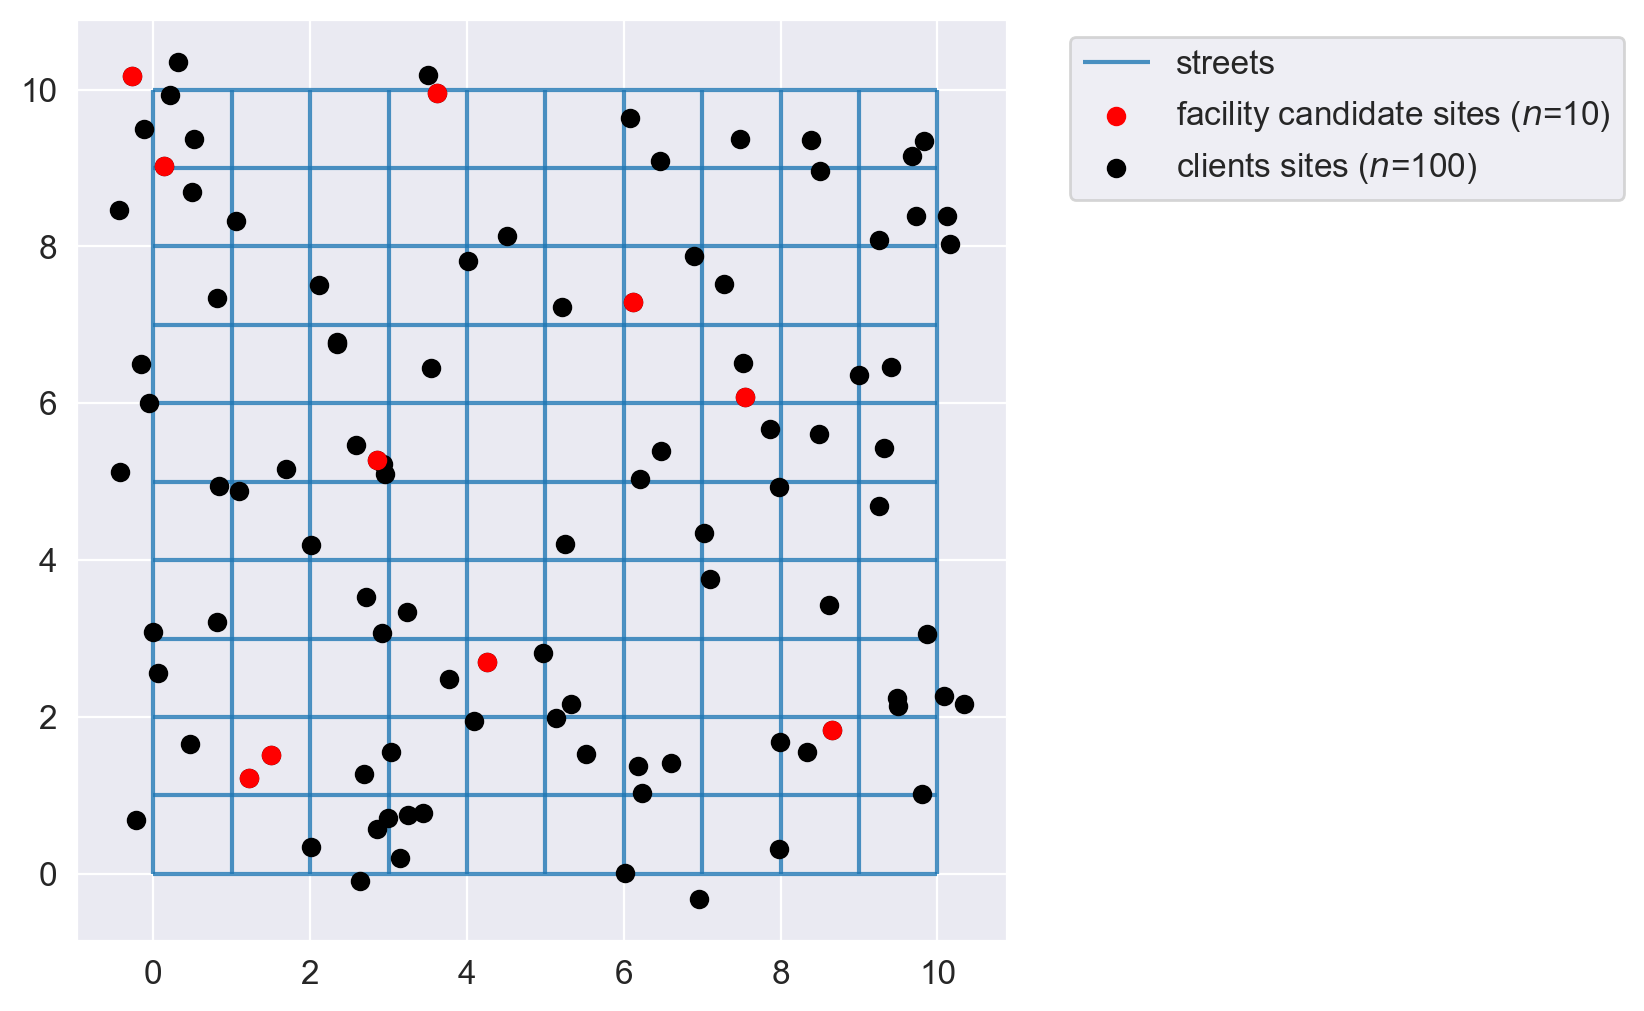

In [173]:
from map_plotter import plot_simulated_grid

plot_simulated_grid(streets, client_points, facility_points, FACILITY_COUNT, CLIENT_COUNT)

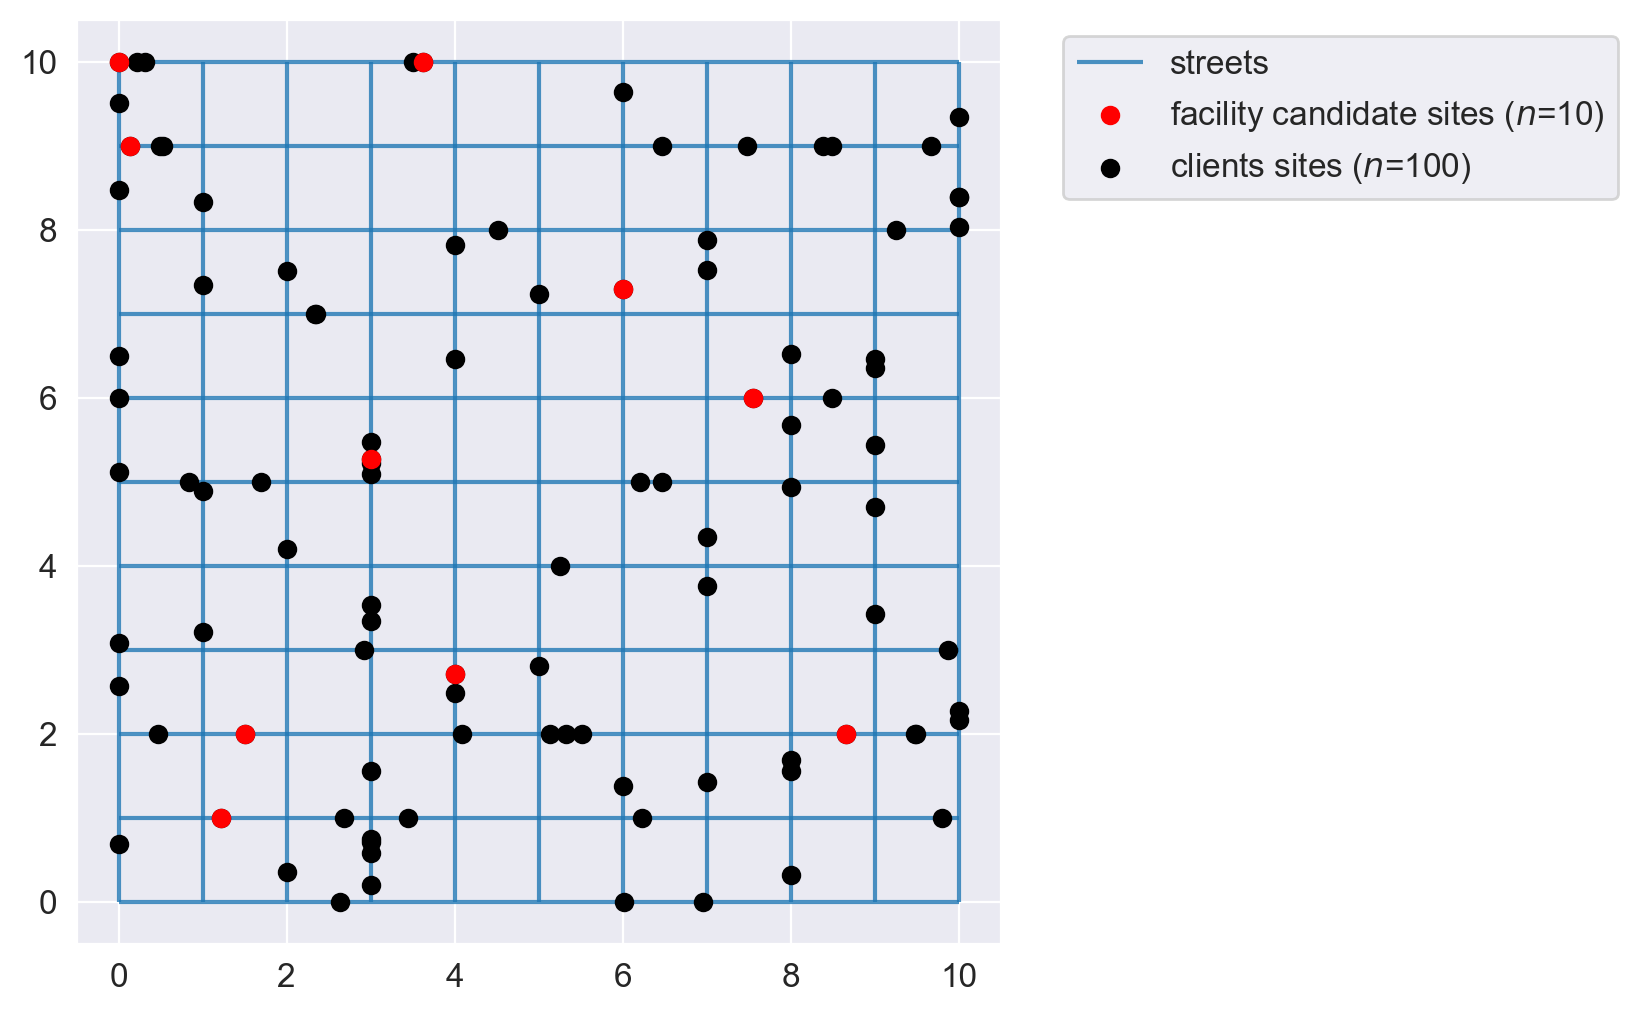

In [174]:
ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(ntw, pp_name="clients", snapped=True)
clients_snapped.drop(columns=["id", "comp_label"], inplace=True)

ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(ntw, pp_name="facilities", snapped=True)
facilities_snapped.drop(columns=["id", "comp_label"], inplace=True)

plot_simulated_grid(streets, clients_snapped, facilities_snapped, FACILITY_COUNT, CLIENT_COUNT)

In [175]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)

In [176]:
from spopt.locate import LSCP

lscp_from_cm = LSCP.from_cost_matrix(
    cost_matrix, SERVICE_RADIUS, name="LSCP"
)
benchmarking_results(lscp_from_cm, 'Number of Facilities')

,Number of Facilities,Time (in sec.)
PULP_CBC_CMD,2.0,0.642922
SCIP_PY,2.0,0.03773
GLPK_CMD,2,0.022141
HiGHS,2.0,0.013567


In [177]:
def create_cost_matrix(model_name, city_size_mult=1):
    if model_name == 'lscp':
        client_count = 10*city_size_mult
        facility_count = 10*city_size_mult
    elif model_name in ['p-median', 'MCLP']:
        client_count = 100*city_size_mult
        facility_count = 10*city_size_mult

    lattice = spaghetti.regular_lattice((0, 0, facility_count, facility_count), facility_count - 1, exterior=True)
    ntw = spaghetti.Network(in_data=lattice)
    streets = spaghetti.element_as_gdf(ntw, arcs=True)
    streets_buffered = gpd.GeoDataFrame(
        gpd.GeoSeries(streets["geometry"].buffer(0.5).unary_union),
        crs=streets.crs,
        columns=["geometry"],
    )

    client_points = simulated_geo_points(
        streets_buffered, needed=client_count, seed=CLIENT_SEED
    )
    facility_points = simulated_geo_points(
        streets_buffered, needed=facility_count, seed=FACILITY_SEED
    )

    ntw.snapobservations(client_points, "clients", attribute=True)
    clients_snapped = spaghetti.element_as_gdf(ntw, pp_name="clients", snapped=True)
    clients_snapped.drop(columns=["id", "comp_label"], inplace=True)

    ntw.snapobservations(facility_points, "facilities", attribute=True)
    facilities_snapped = spaghetti.element_as_gdf(ntw, pp_name="facilities", snapped=True)
    facilities_snapped.drop(columns=["id", "comp_label"], inplace=True)

    return ntw.allneighbordistances(sourcepattern=ntw.pointpatterns["clients"],
                                    destpattern=ntw.pointpatterns["facilities"],)

In [178]:
df = pd.DataFrame()
for size in [1, 3, 7, 10]:
    costs = create_cost_matrix('lscp', size)
    lscp_from_cm = LSCP.from_cost_matrix(costs, size, name="LSCP")
    result_df = benchmarking_results(lscp_from_cm, 'Number of Facilities')
    result_df['size'] = 10*size
    df = pd.concat([df, result_df])
    print(f'solved for size = {size}')
df = df.reset_index()

solved for size = 1
solved for size = 3
solved for size = 7
solved for size = 10


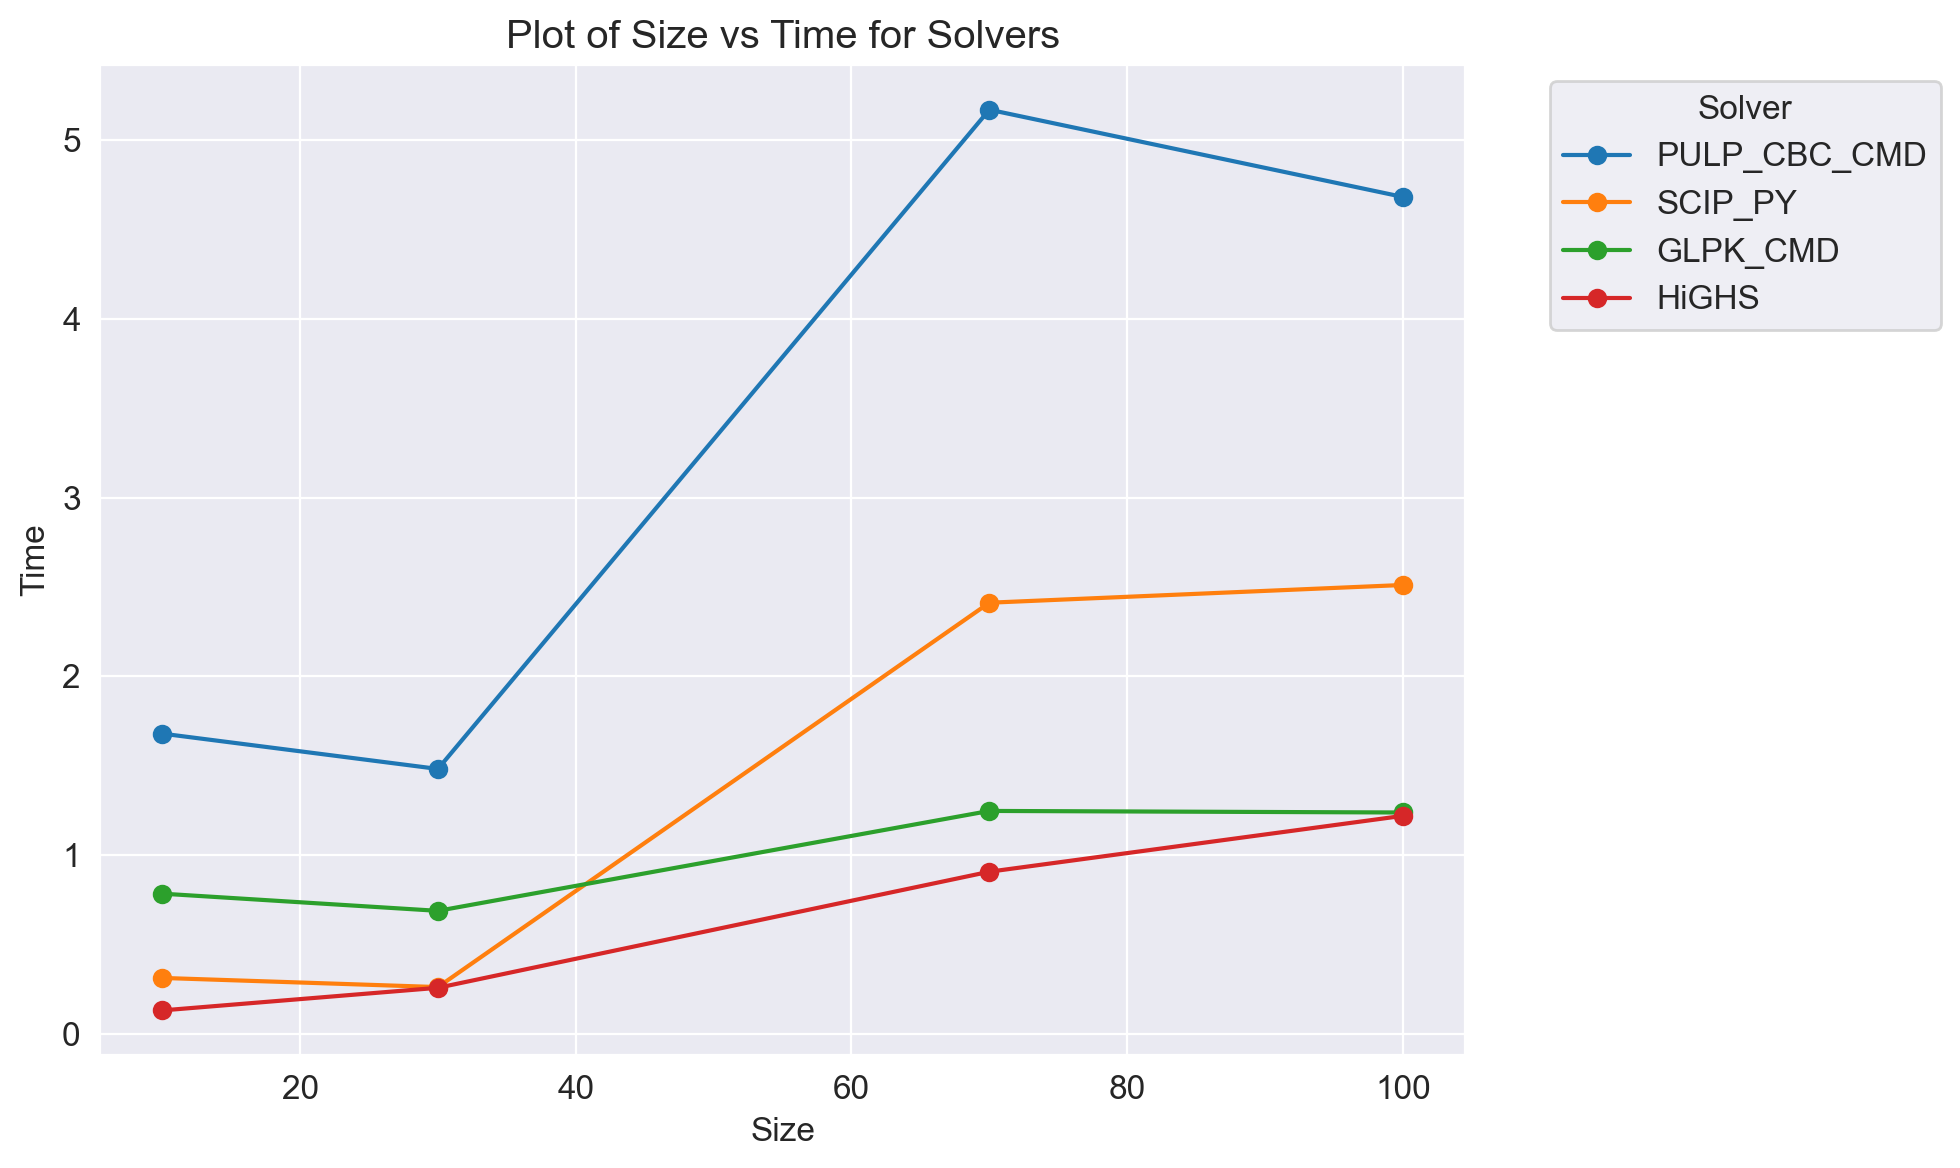

In [ ]:
unique_names = df['index'].unique()
df['Time (in sec.)'] = 100*df['Time (in sec.)']

plt.figure(figsize=(10, 6))

for name in unique_names:
    subset = df[df['index'] == name]
    plt.plot(subset['size'], subset['Time (in sec.)'], marker='o', label=name)  # 'o' adds points at each x-y pair

plt.xlabel('Size')
plt.ylabel('Time')
plt.title('Plot of Size vs Time for Solvers')
plt.legend(title='Solver', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## MCLP

In [180]:
from spopt.locate import MCLP

cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
client_points["weights"] = np.random.randint(1, 20, CLIENT_COUNT)

In [181]:
pmedian_from_cm = MCLP.from_cost_matrix(
    cost_matrix,
    client_points["weights"],
    service_radius=4,
    p_facilities=4,
    name="MCLP"
)
benchmarking_results(pmedian_from_cm, 'Coverage (%)', True)

,Coverage (%),Time (in sec.)
PULP_CBC_CMD,83.0,0.021846
SCIP_PY,83.0,0.005049
GLPK_CMD,83.0,0.00813
HiGHS,83.0,0.003206


In [182]:
df2 = pd.DataFrame()
for size in [1, 3, 7, 10]:
    costs = create_cost_matrix("MCLP", size)
    weights = np.random.randint(1, 15, 100)
    pmedian_from_cm = MCLP.from_cost_matrix(cost_matrix,
                                               weights,
                                               p_facilities=4,
                                               service_radius=4,
                                               name="MCLP")
    result_df = benchmarking_results(pmedian_from_cm, 'Minimized Weighted Distance')
    result_df['size'] = 10*size
    df2 = pd.concat([df2, result_df])
    print(f'solved for size = {size}')
df2 = df2.reset_index()

solved for size = 1
solved for size = 3
solved for size = 7
solved for size = 10


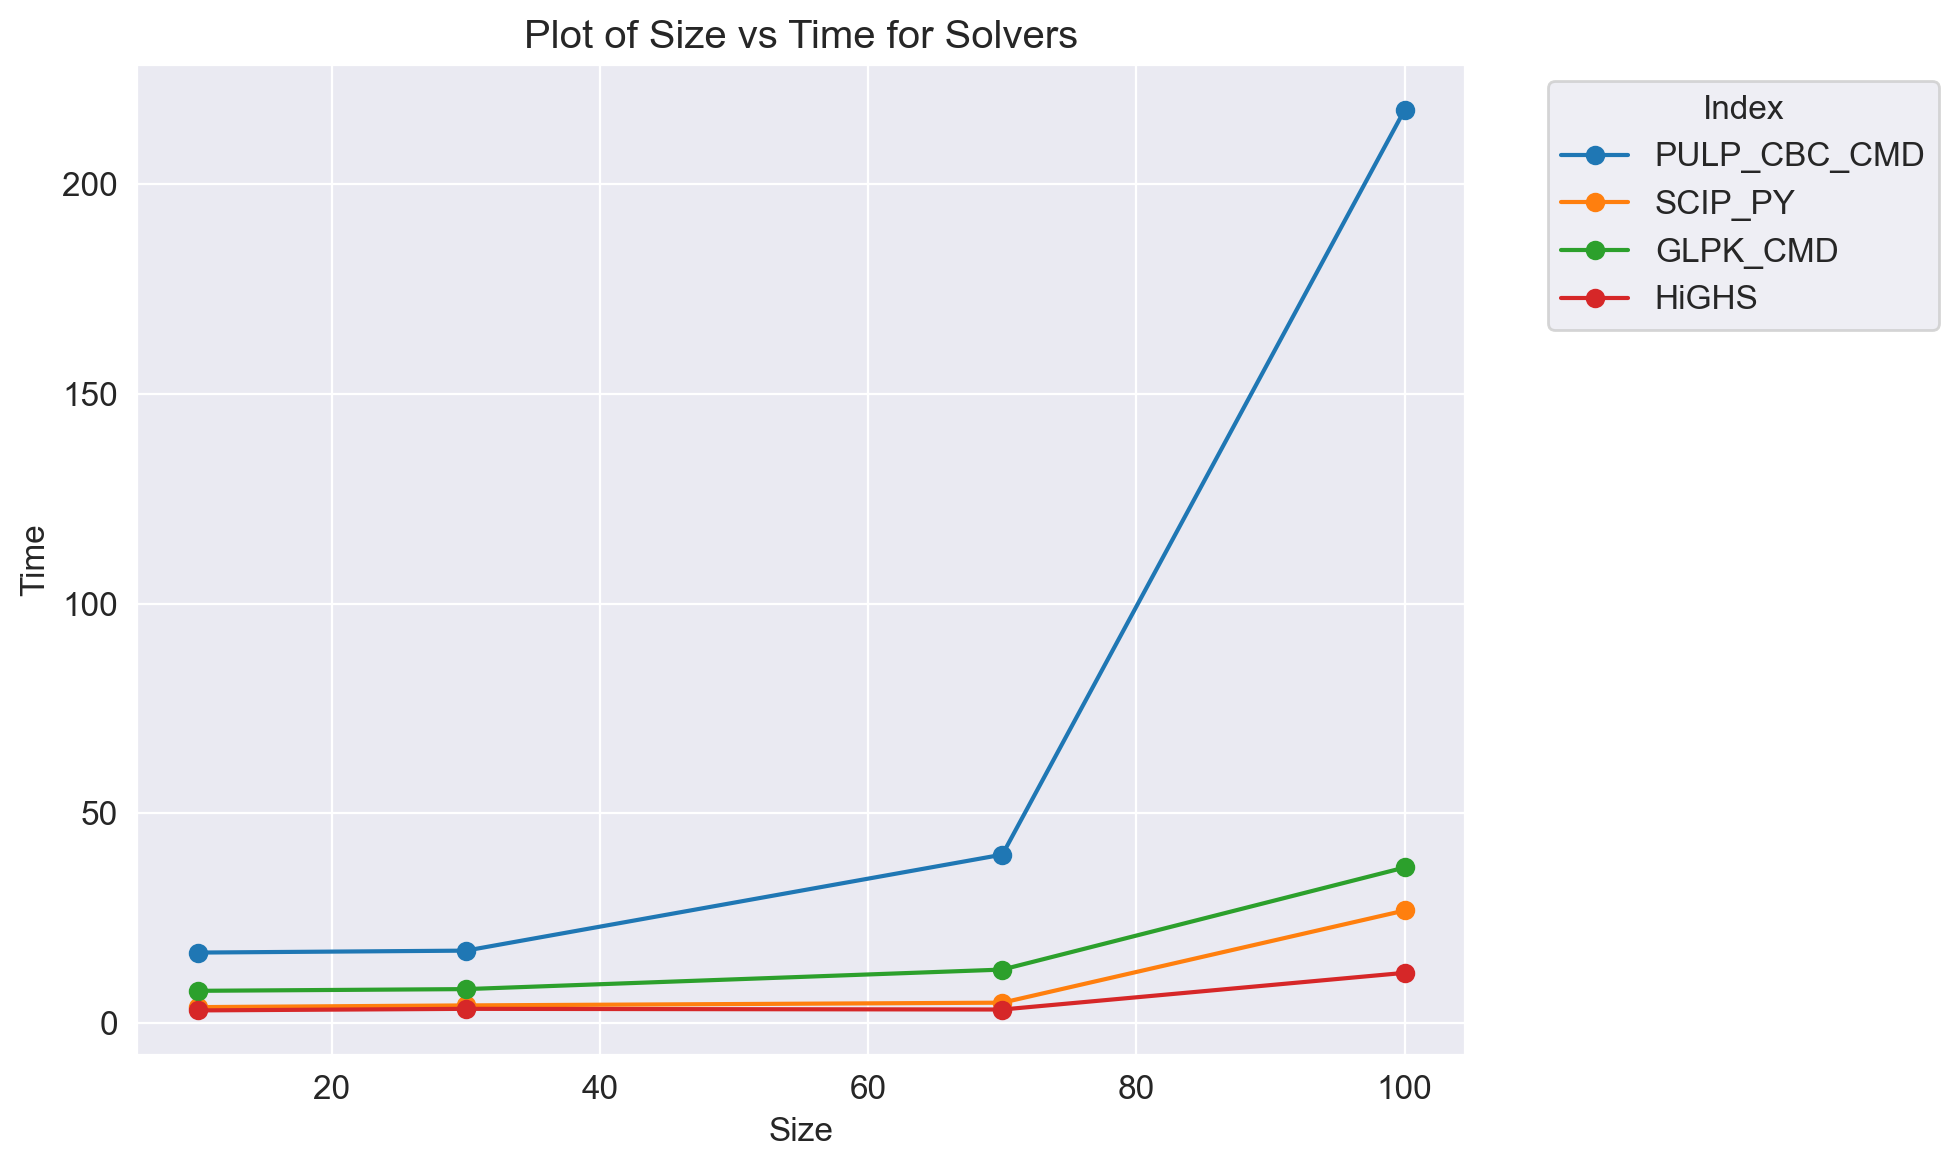

In [ ]:
unique_names = df2['index'].unique()
df2['Time (in sec.)'] =  1000*df2['Time (in sec.)']
plt.figure(figsize=(10, 6))

for name in unique_names:
    subset = df2[df2['index'] == name]
    plt.plot(subset['size'], subset['Time (in sec.)'], marker='o', label=name)

plt.xlabel('Size')
plt.ylabel('Time')
plt.title('Plot of Size vs Time for Solvers')
plt.legend(title='Index', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## $p$-median

In [184]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
client_points["weights"] = np.random.randint(1, 20, CLIENT_COUNT)

In [185]:
from spopt.locate import PMedian

pmedian_from_cm = PMedian.from_cost_matrix(
    cost_matrix,
    client_points["weights"],
    p_facilities=4,
    name="p-median-network-distance"
)
benchmarking_results(pmedian_from_cm, 'Minimized Weighted Distance')

,Minimized Weighted Distance,Time (in sec.)
PULP_CBC_CMD,2801.02603,0.041238
SCIP_PY,2801.02603,0.034242
GLPK_CMD,2801.02603,0.030131
HiGHS,2801.02603,0.020524


In [186]:
df3 = pd.DataFrame()
for size in [1, 3, 7, 10]:
    costs = create_cost_matrix("p-median", size)
    weights = np.random.randint(1, 15, 100)
    pmedian_from_cm = PMedian.from_cost_matrix(cost_matrix,
                                               weights,
                                               p_facilities=4,
                                               name="p-median")
    result_df = benchmarking_results(pmedian_from_cm, 'Minimized Weighted Distance')
    result_df['size'] = 10*size
    df3 = pd.concat([df3, result_df])
df3 = df3.reset_index()

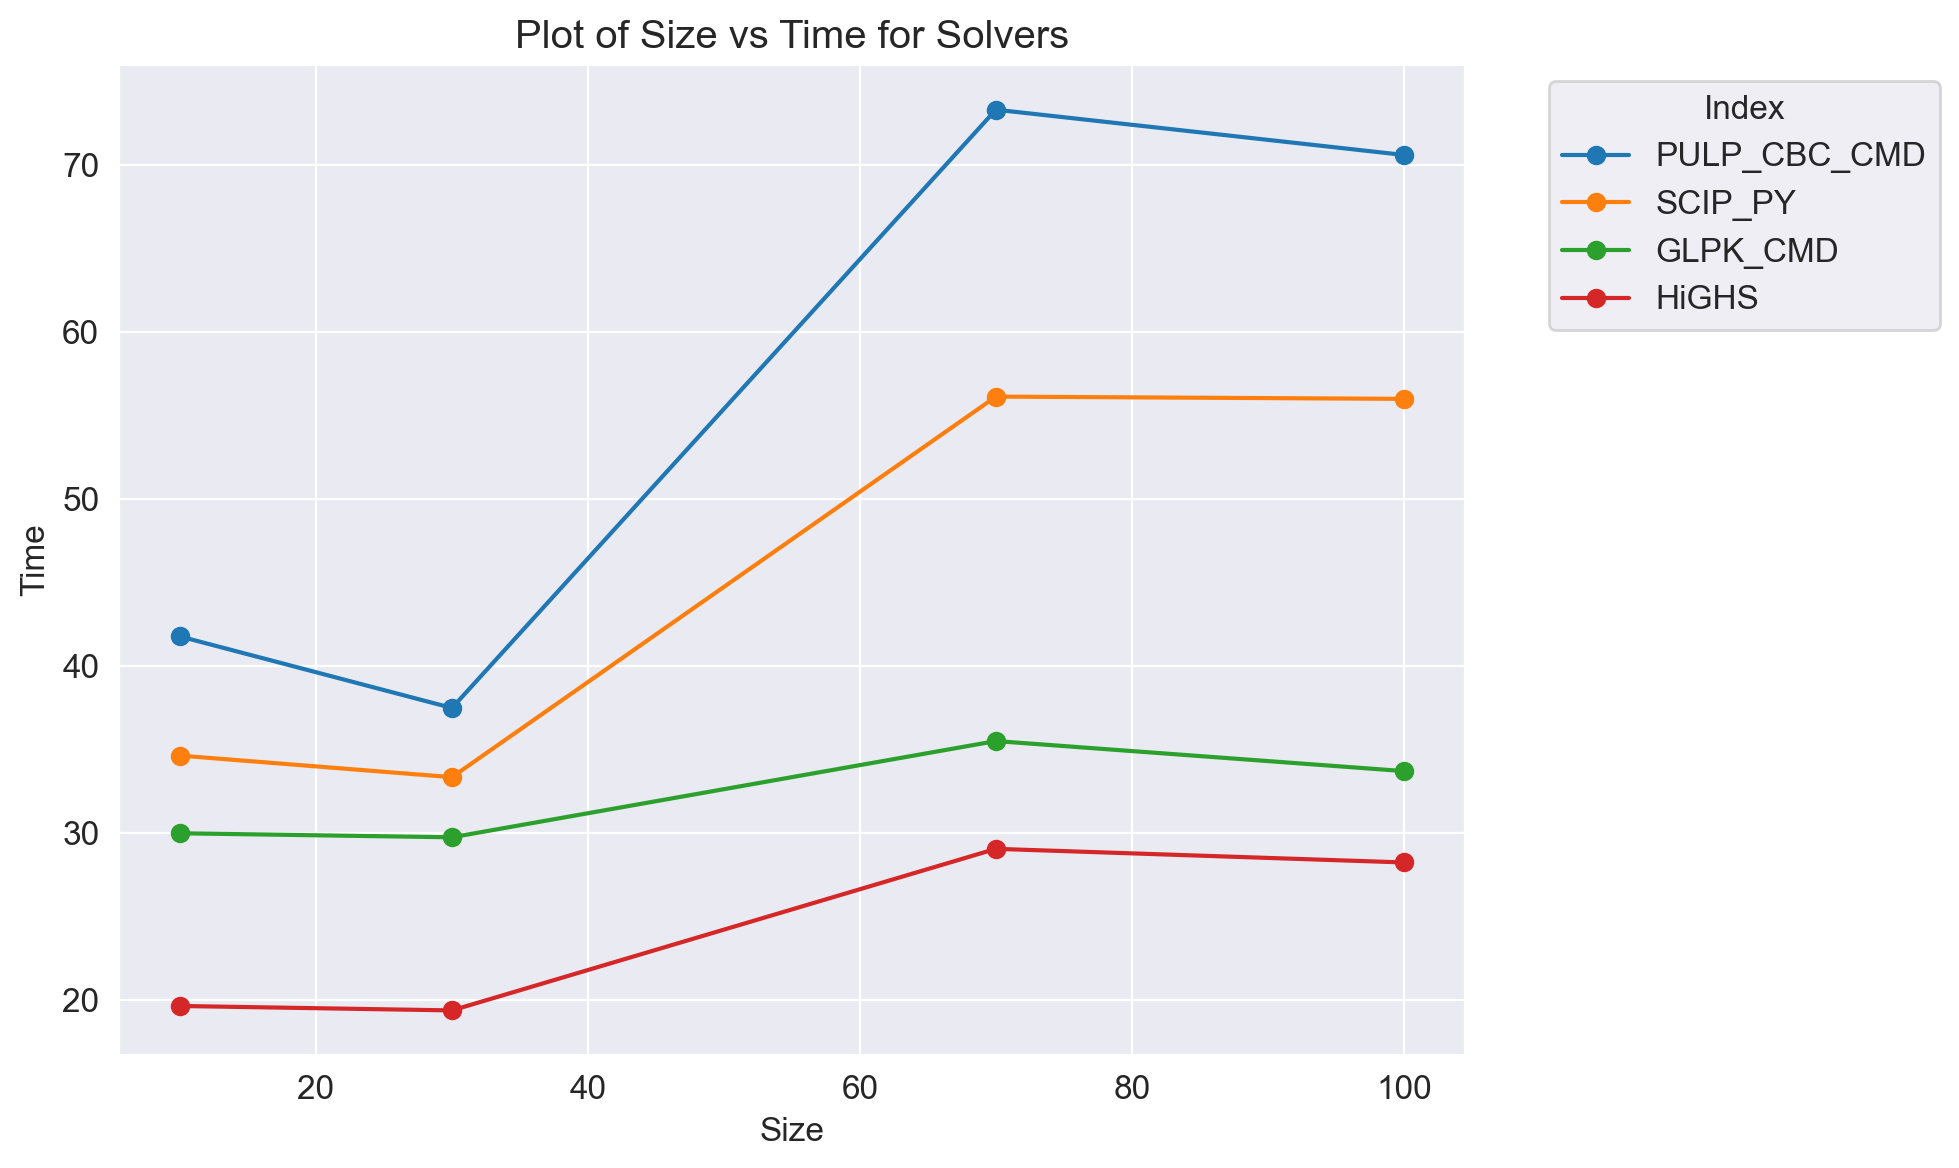

In [188]:
unique_names = df3['index'].unique()
df3['Time (in sec.)'] = 1000*df3['Time (in sec.)']
plt.figure(figsize=(10, 6))

for name in unique_names:
    subset = df3[df3['index'] == name]
    plt.plot(subset['size'], subset['Time (in sec.)'], marker='o', label=name)

plt.xlabel('Size')
plt.ylabel('Time')
plt.title('Plot of Size vs Time for Solvers')
plt.legend(title='Index', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Empirical Data Benchmarking

Data Source: https://github.com/huanfachen/Open_source_location_cover_models/tree/master/Data/San_Francisco_store

In [189]:
# Data

distance = pd.read_csv('SF_network_distance_candidateStore_16_censusTract_205_new.csv')
cost_matrix = distance.pivot_table(
    values="distance", index="DestinationName", columns="name"
).to_numpy()

demand_points = pd.read_csv('SF_demand_205_centroid_uniform_weight.csv')
n_dem_pnts = demand_points.shape[0]

facility_points = pd.read_csv('SF_store_site_16_longlat.csv')
n_fac_pnts = facility_points.shape[0]

## LSCP

In [190]:
from spopt.locate import LSCP

lscp = LSCP.from_cost_matrix(cost_matrix, service_radius=5000)
lscp = lscp.solve(pulp.GLPK(msg=False))
lscp_objval = lscp.problem.objective.value()
facility_points["dv"] = lscp.fac_vars
facility_points["dv"] = facility_points["dv"].map(lambda x: x.name.replace("_", ""))
facility_points["predefined_loc"] = 0

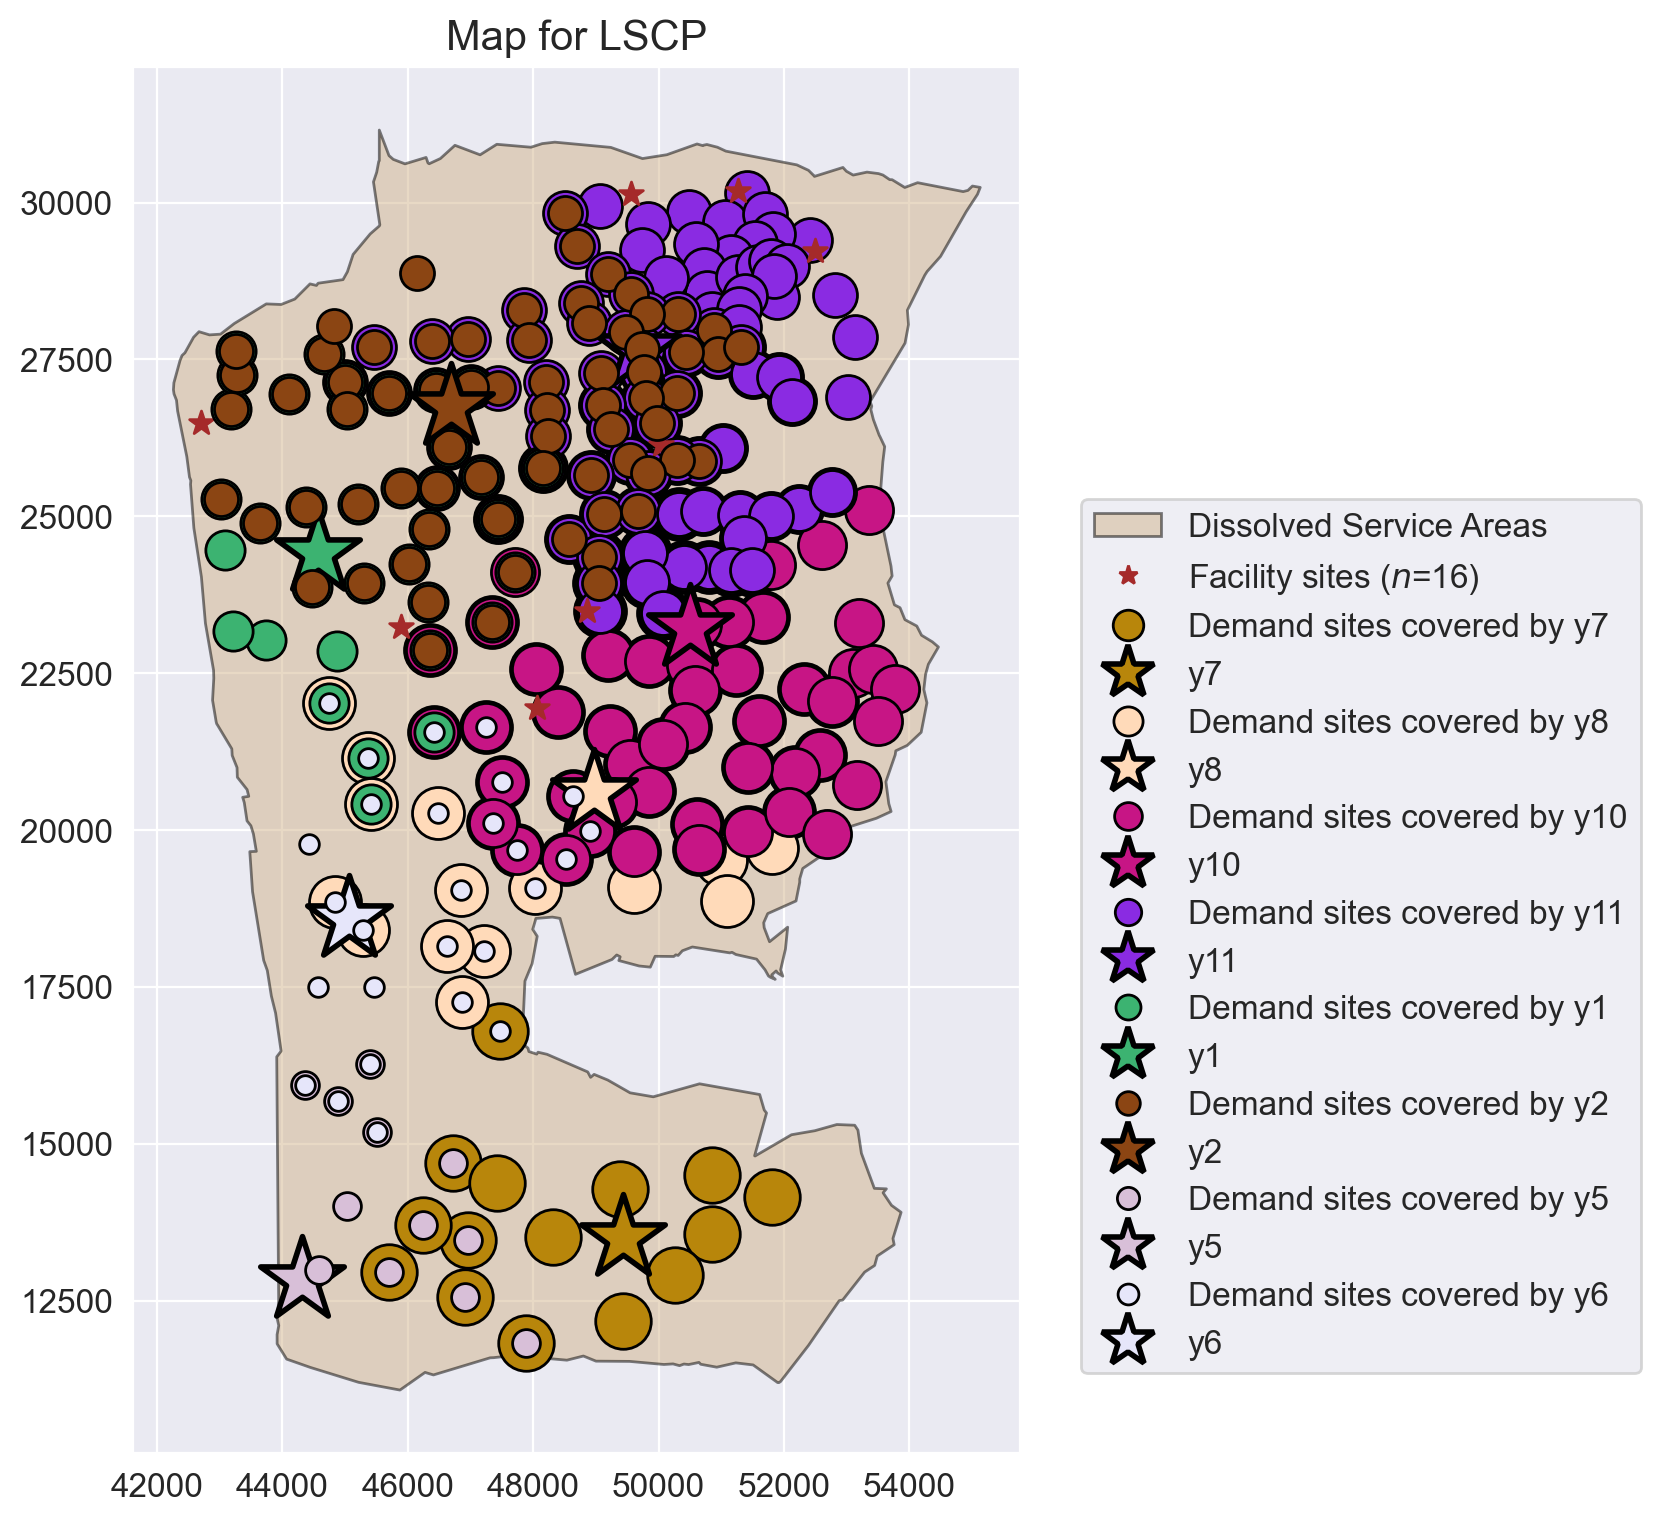

In [191]:
from map_plotter import plot_results_on_map

map_area = gpd.read_file('ServiceAreas_4.shp').dissolve()
plot_results_on_map(lscp, lscp_objval, facility_points, map_area, clis=demand_points)

In [192]:
lscp = LSCP.from_cost_matrix(cost_matrix, 5000)
benchmarking_results(lscp, 'Number of Facilities')

,Number of Facilities,Time (in sec.)
PULP_CBC_CMD,8.0,0.022285
SCIP_PY,8.0,0.003867
GLPK_CMD,8,0.009429
HiGHS,8.0,0.002994


## MCLP

In [193]:
from spopt.locate import MCLP
mclp = MCLP.from_cost_matrix(
    cost_matrix, demand_points["POP2000"].to_numpy(), service_radius=5000, p_facilities=4,
)
mclp = mclp.solve(pulp.GLPK(msg=False))
mclp.perc_cov

90.2439024390244

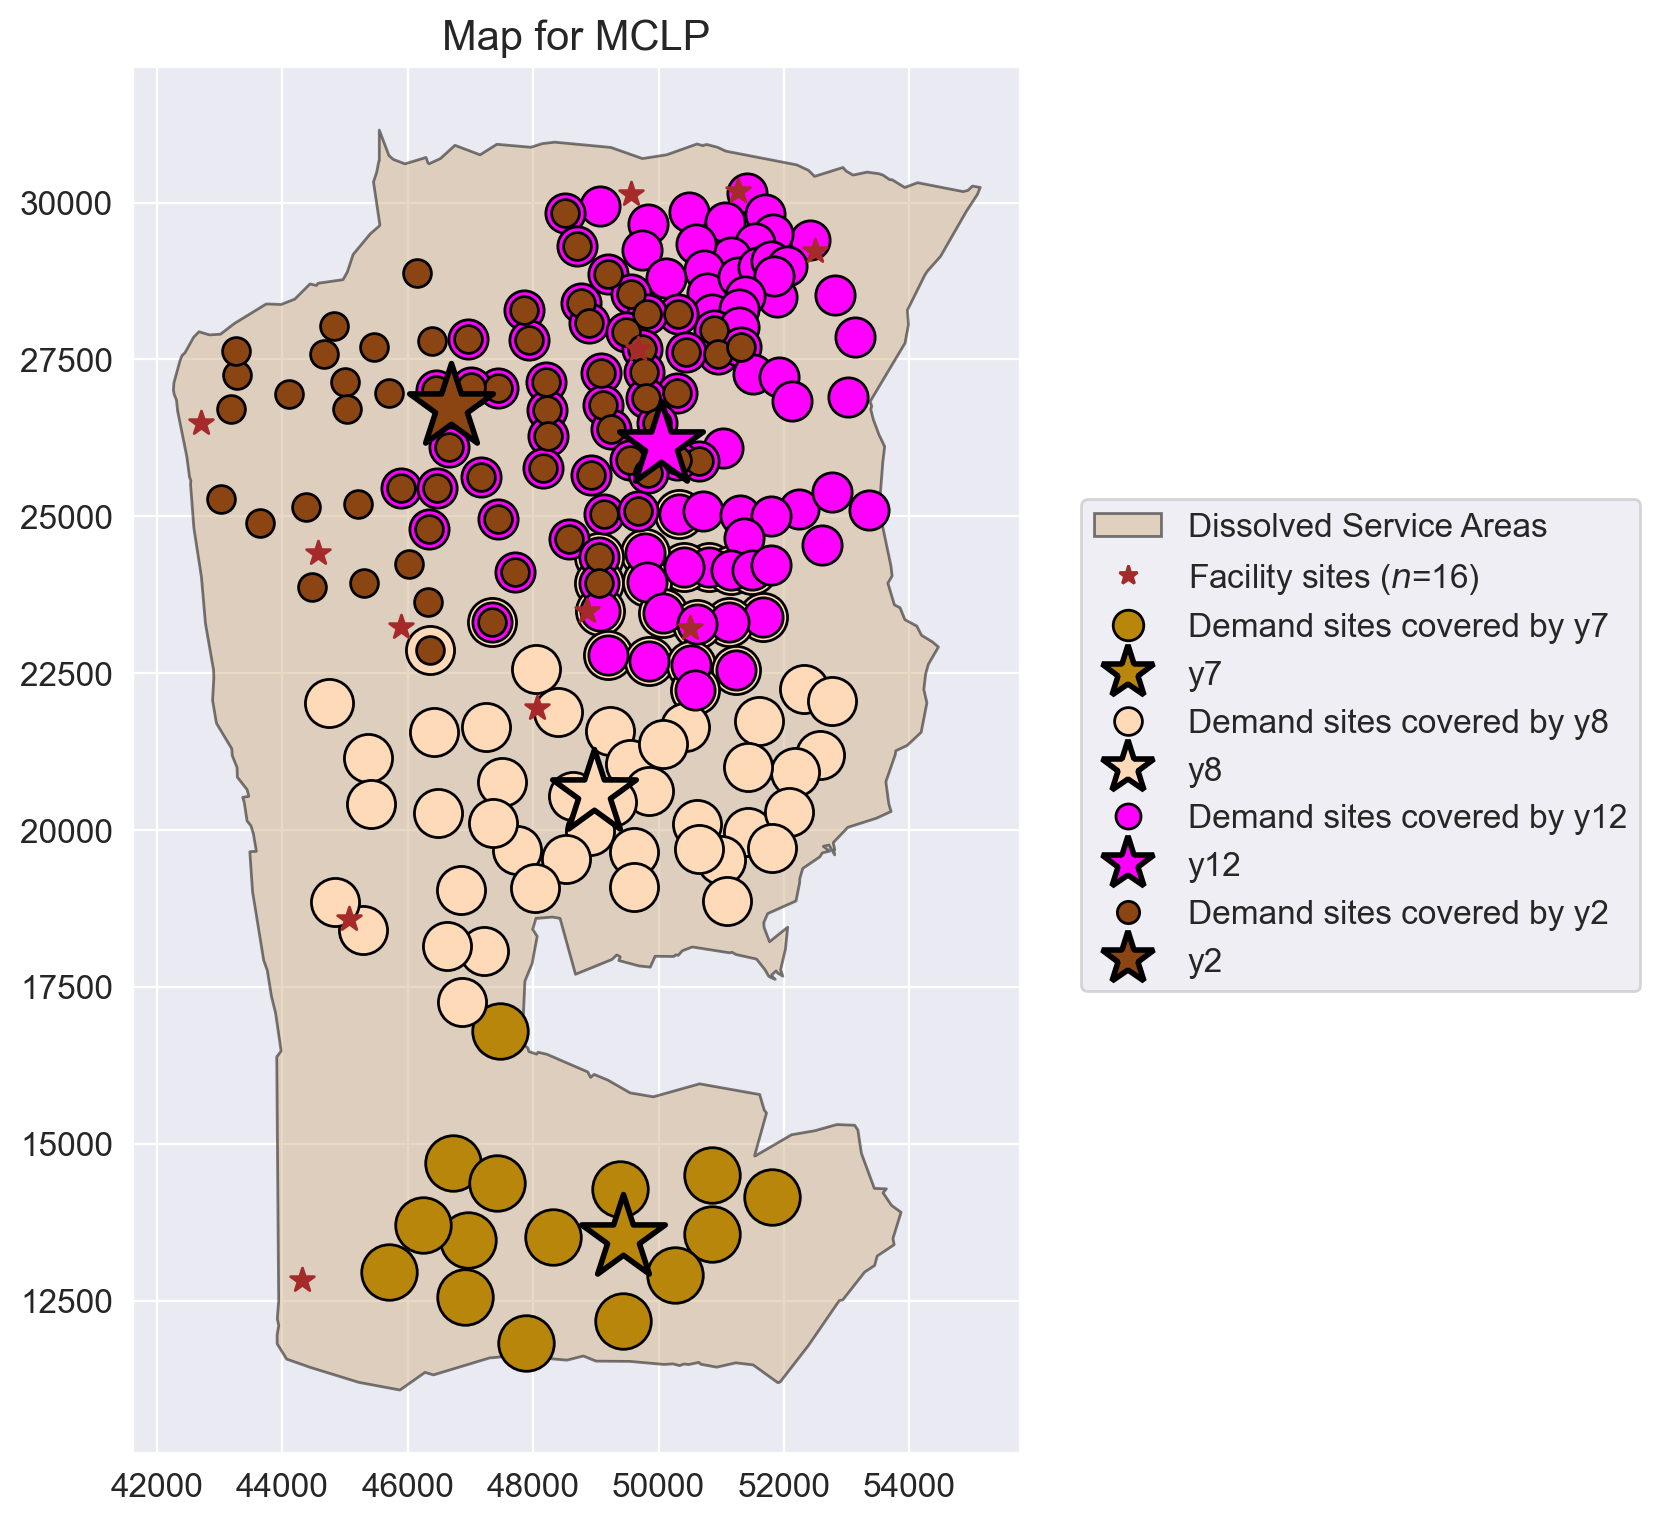

In [194]:
map_area = gpd.read_file('ServiceAreas_4.shp').dissolve()
plot_results_on_map(mclp, 4, facility_points, map_area, clis=demand_points)

In [195]:
p_median = MCLP.from_cost_matrix(cost_matrix, demand_points["POP2000"].to_numpy(), service_radius=5000, p_facilities=4)
benchmarking_results(p_median, 'Coverage (%)', True)

,Coverage (%),Time (in sec.)
PULP_CBC_CMD,90.243902,0.020039
SCIP_PY,90.243902,0.006782
GLPK_CMD,90.243902,0.01173
HiGHS,90.243902,0.005768


## $p$-median

In [196]:
from spopt.locate import PMedian
pmedian = PMedian.from_cost_matrix(cost_matrix, demand_points["POP2000"].to_numpy(), p_facilities=4)
pmedian = pmedian.solve(pulp.GLPK(msg=False))
pmedian.problem.objective.value()

2938326503.9416327

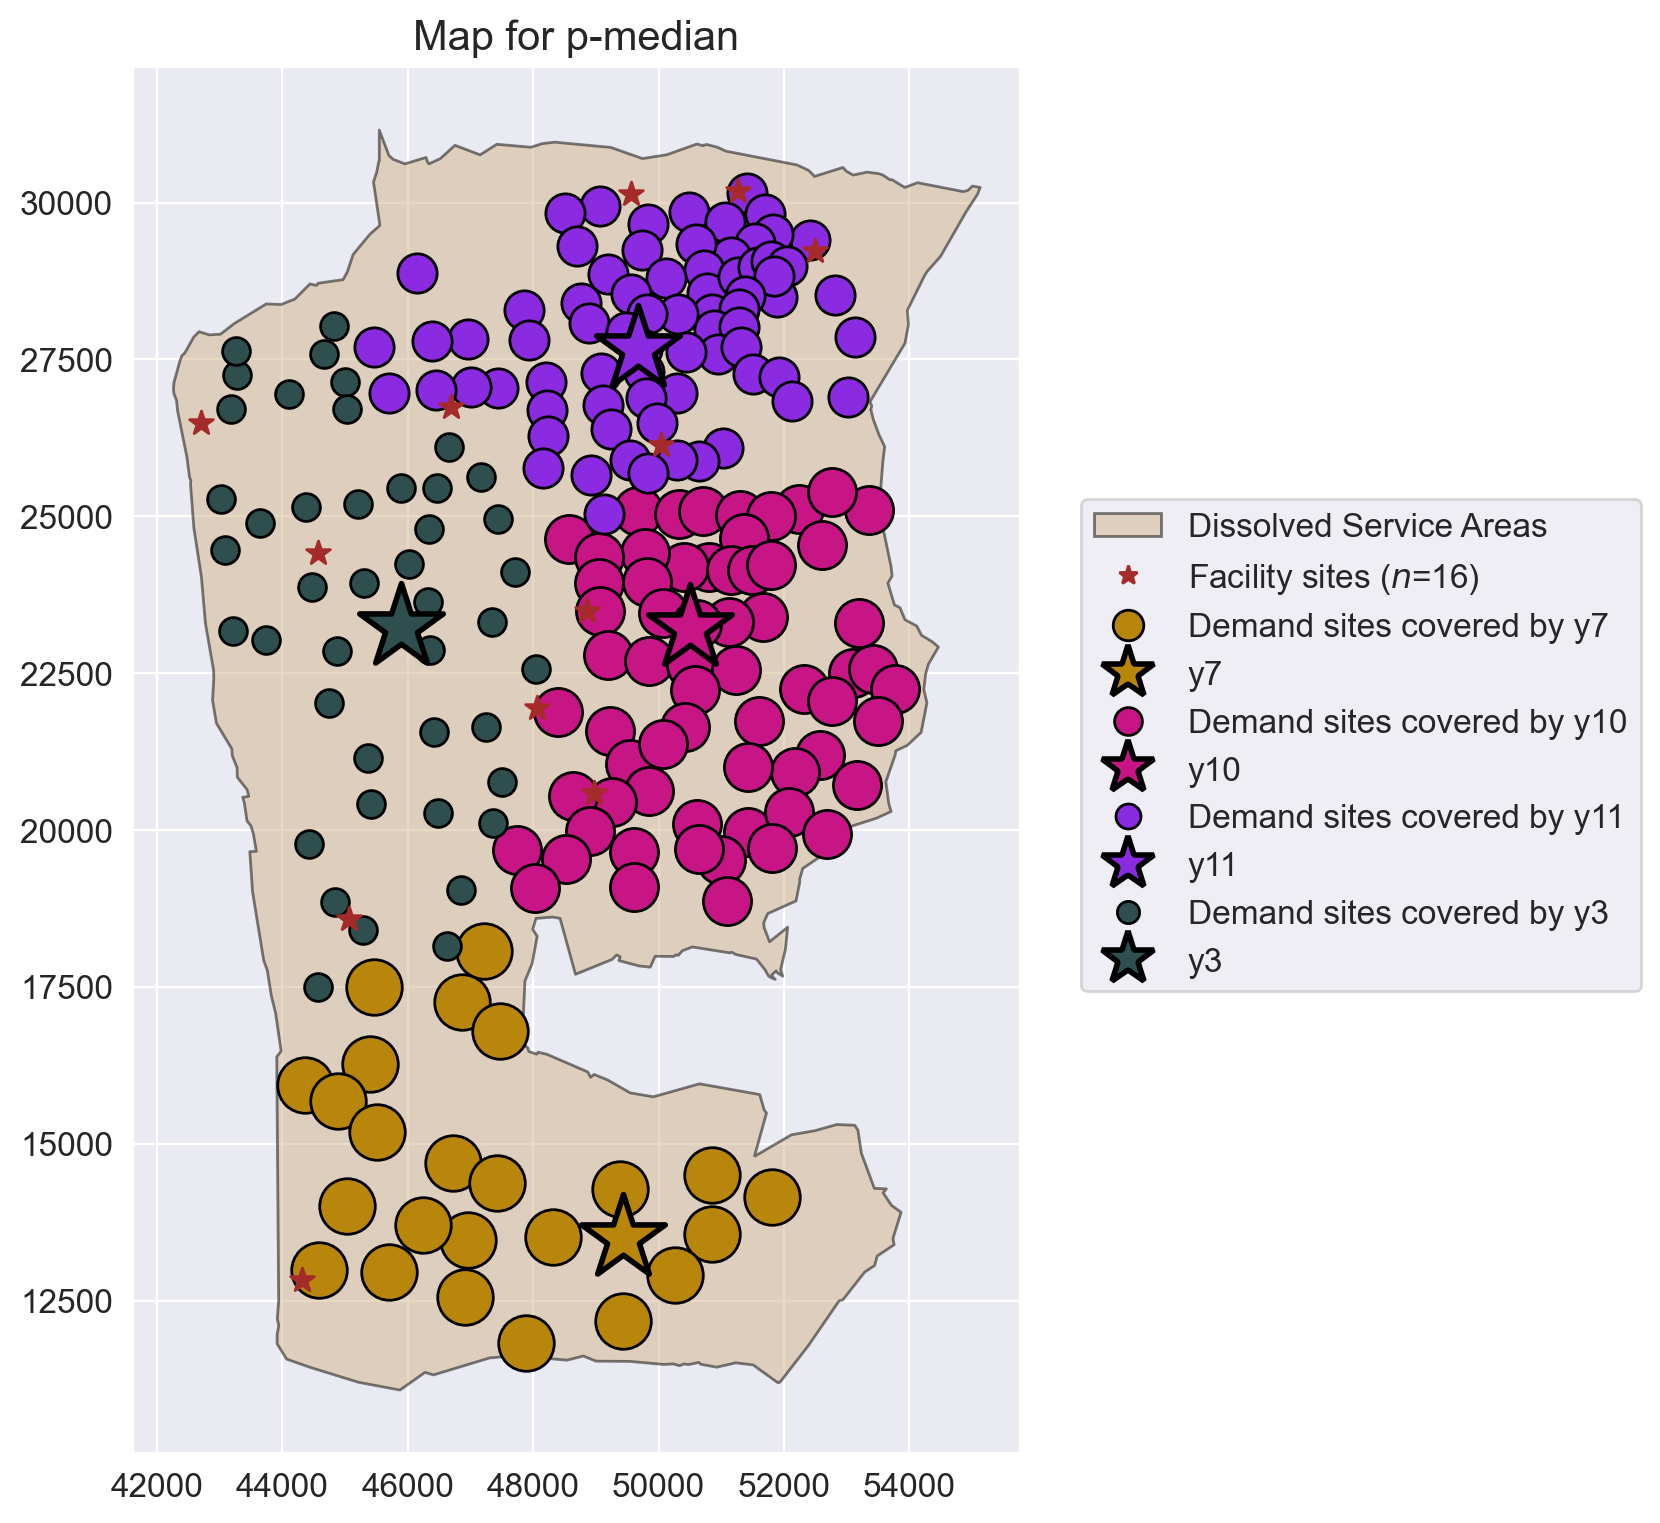

In [197]:
map_area = gpd.read_file('ServiceAreas_4.shp').dissolve()
plot_results_on_map(pmedian, 4, facility_points, gpd.read_file('ServiceAreas_4.shp').dissolve(), clis=demand_points)

In [198]:
p_median = PMedian.from_cost_matrix(cost_matrix, demand_points["POP2000"].to_numpy(), p_facilities=4)
benchmarking_results(p_median, 'Minimized Weighted Distance')

,Minimized Weighted Distance,Time (in sec.)
PULP_CBC_CMD,2938326503.941633,0.146299
SCIP_PY,2938326503.941633,0.11614
GLPK_CMD,2938326503.941633,0.150522
HiGHS,2938326503.941633,0.078325
